# K-MEANS CLUSTERING

### PUNTI DA CHIARIRE:
#### - questione variables da mettere negli assi

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [227]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans
from sklearn.cluster import KMeans
#evaluation
from sklearn.metrics import silhouette_score

In [228]:
df = pd.read_csv("pp_train.csv")
df.head()

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,worstRating,bestRating,totalImages,...,is_War,is_Sci-Fi,is_Talk-Show,is_Adventure,is_Film-Noir,is_Music,is_Western,is_Comedy,is_Drama,fill_runtimeMinutes
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,NaN,NaN,0.0,779,1,10,1,...,0,0,0,1,0,0,0,0,0,40.0
1,Looping,6,1982,NaN,NaN,0.0,11,1,10,1,...,0,0,0,0,0,0,0,0,0,28.0
2,Idealnaya para,6,1992,NaN,NaN,0.0,38,1,10,1,...,0,0,0,0,0,0,0,1,0,90.0
3,MasterChef Celebrity México,6,2021,NaN,NaN,0.0,15,1,10,22,...,0,0,0,0,0,0,0,0,0,31.0
4,Seutateueob,8,2020,2020.0,80.0,1.0,15718,1,10,347,...,0,0,0,0,0,0,0,1,1,80.0


In [229]:
df.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'worstRating', 'bestRating', 'totalImages',
       'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType',
       'awardNominationsExcludeWins', 'canHaveEpisodes', 'isRatable',
       'isAdult', 'numRegions', 'userReviewsTotal', 'ratingCount',
       'countryOfOrigin', 'is_Thriller', 'is_Family', 'is_Short', 'is_Sport',
       'is_Biography', 'is_Musical', 'is_Game-Show', 'is_Crime', 'is_Mystery',
       'is_Horror', 'is_Romance', 'is_Animation', 'is_Fantasy', 'is_Action',
       'is_Documentary', 'is_News', 'is_History', 'is_Adult', 'is_Reality-TV',
       'is_War', 'is_Sci-Fi', 'is_Talk-Show', 'is_Adventure', 'is_Film-Noir',
       'is_Music', 'is_Western', 'is_Comedy', 'is_Drama',
       'fill_runtimeMinutes'],
      dtype='object')

In [230]:
features = df[['fill_runtimeMinutes', "numVotes"]]
#features = df[["awardWins", "numVotes", "worstRating", "bestRating", "totalImages", "totalVideos", "totalCredits", "criticReviewsTotal", "awardNominationsExcludeWins", "numRegions", "userReviewsTotal", "ratingCount", "fill_runtimeMinutes"]]
X = features.values

#### mapping della variabile target (per noi è titleType) così da confrontarla dopo con gli eventuali cluster

In [231]:
y = np.array(df['titleType'])
y_map = {0: "tvEpisode", 1: "videoGame", 2: "movie", 3:"tvSeries", 4: "video", 5: "tvMiniSeries", 6: "short", 7: "tvMovie", 8: "tvSpecial", 9: "tvShort"}
y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map) #target label

### normalizzazione con z-score e minmax

In [232]:
scaler = StandardScaler() 
scaler.fit(X) #x è la numpy matrix of the dataset
X_scal = scaler.transform(X)

In [233]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

### inizializzazione modello

In [234]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94) #inizializziamo algoritmo, fit it per lavorare sull'exact data
#iniziamo con 3 cluster, 10 iterations, random_state: allows to have the same result 

#kmeans.fit(X_scal)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=94)

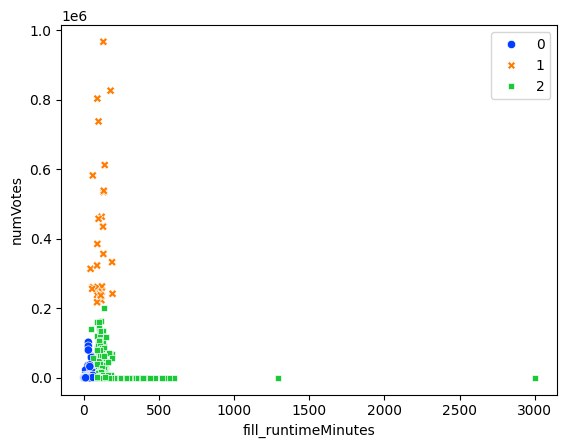

In [235]:
sns.scatterplot(data=df, 
                x="fill_runtimeMinutes",
                y="numVotes",
                hue=kmeans.labels_,
                style=kmeans.labels_, #usiamo labels date da k-means
                palette="bright")
plt.show()

### identificazione dei centroidi

In [236]:
kmeans.cluster_centers_ #coordinates with centroids

array([[1.05958878e-02, 3.13829757e-04],
       [3.66206897e-02, 4.21712229e-01],
       [3.23328352e-02, 1.49507620e-03]])

In [237]:
centers = scaler.inverse_transform(kmeans.cluster_centers_) #from normalized to input domain
centers

array([[3.17876635e+01, 3.08335290e+02],
       [1.09862069e+02, 4.07615172e+05],
       [9.69985055e+01, 1.45008085e+03]])

In [238]:
df['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})

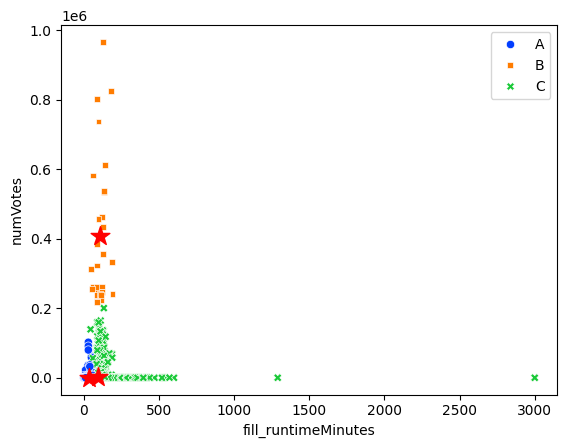

In [239]:
sns.scatterplot(data=df, 
                x="fill_runtimeMinutes", 
                y="numVotes", 
                hue='kmeans_labels', 
                style='kmeans_labels',
                palette="bright", 
                hue_order=["A", "B", "C"]
               )
plt.legend()
plt.scatter(centers[:,0], centers[:,1], c='red', marker='*', s=200) #plotting the centroids
plt.show()

### conronto con target variable

In [240]:
y_mapped

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
16426    NaN
16427    NaN
16428    NaN
16429    NaN
16430    NaN
Name: 0, Length: 16431, dtype: object

In [241]:
y_mapped.groupby(df['kmeans_labels']).value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

### metrics

In [242]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax, kmeans.labels_))

SSE 4.060271418111089
Silhouette 0.6444084447114099


In [243]:
%%time
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)

CPU times: total: 4.8 s
Wall time: 11.4 s


In [244]:
sil_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sil_list.append(silhouette_score(X_minmax, kmeans.labels_))

KeyboardInterrupt: 

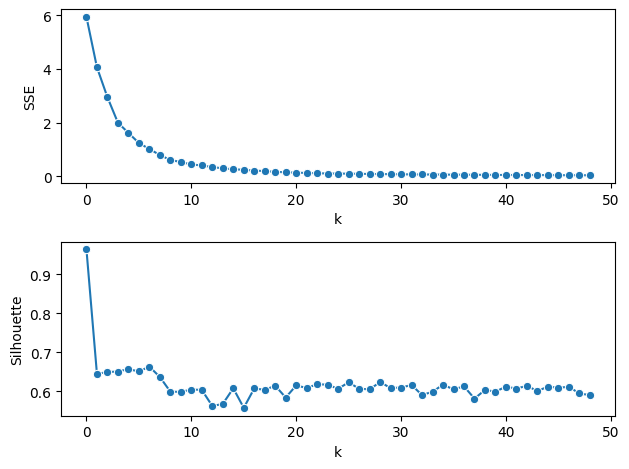

In [ ]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout()